# Plot PPSD on the BP network
2023.04.14 Kurama Okubo

This notebook plot PPSD on the BP network to check the consistency in ambient seismic noise strength.

- 2023.04.26 Update to plot PPSD 3 components with 3 columns

## How to plot PPSD
1. Compute the daily-stacked auto-correlation funtions and correct the channels using `SeisMonitoring.jl`.
2. Run `BP_autocorrPSD.jl` to compute PPSD based on Blackman–Tukey method.
3. Plot the figure with this notebook.


In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import matplotlib.dates as dates
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
import warnings
import h5py

from matplotlib.patches import Rectangle, Circle, Ellipse
import matplotlib.cm as cm

import seaborn as sns # to plot heatmap
import matplotlib.dates as mdates
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize


plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion


In [2]:
datadir = "../SeisMonitoring_PPSDdata/PPSD_data"
output_imgdir="../figure_3cols"

if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)    

In [3]:
complist = ["11", "22", "33"]
# read the data
filelist = glob(datadir+"/*.jld2")

# search station pairs
stations = []
for fname in filelist:
    stations.append(os.path.basename(fname).split(".jld2")[0].split("_")[1].split("-")[0])
    
stations = np.unique(stations)

sta = stations[1]

ppsd_dict = dict()
for comp in complist:
    finame= datadir+f"/PPSDdata_{sta}-{sta}-{comp}.jld2"
    # read psd data
    fi = h5py.File(finame, "r")
    tvec_all = [datetime.datetime.fromtimestamp(x) for x in fi["tvec_all"][()]]
    fs = fi["fs"][()]
    Spfreq_DSP = fi["Spfreq"][()]
    Sp_all = np.transpose(fi["Sp_all"][()])
    ppsd_dict[f"{comp}-tvec_all"] = tvec_all
    ppsd_dict[f"{comp}-fs"] = fs
    ppsd_dict[f"{comp}-Spfreq_DSP"] = Spfreq_DSP
    ppsd_dict[f"{comp}-Sp_all"] = Sp_all

In [4]:
# recompute the list of rfftfreq with numpy
Nlag = 2*(Sp_all.shape[0]-1) + 1
Spfreq = np.fft.rfftfreq(Nlag, d=1/fs)
dfreq = Spfreq[2] - Spfreq[1]

# assert if the step size of frequency band is identical to Julia DSP.rfftfreq
assert np.abs(Spfreq_DSP[2] - dfreq)  < 1e-12

In [5]:
Sp_all.shape

(2401, 7404)

# Plot the PPSD

In [6]:
def pow2db(x):
    return 10*np.log10(x)

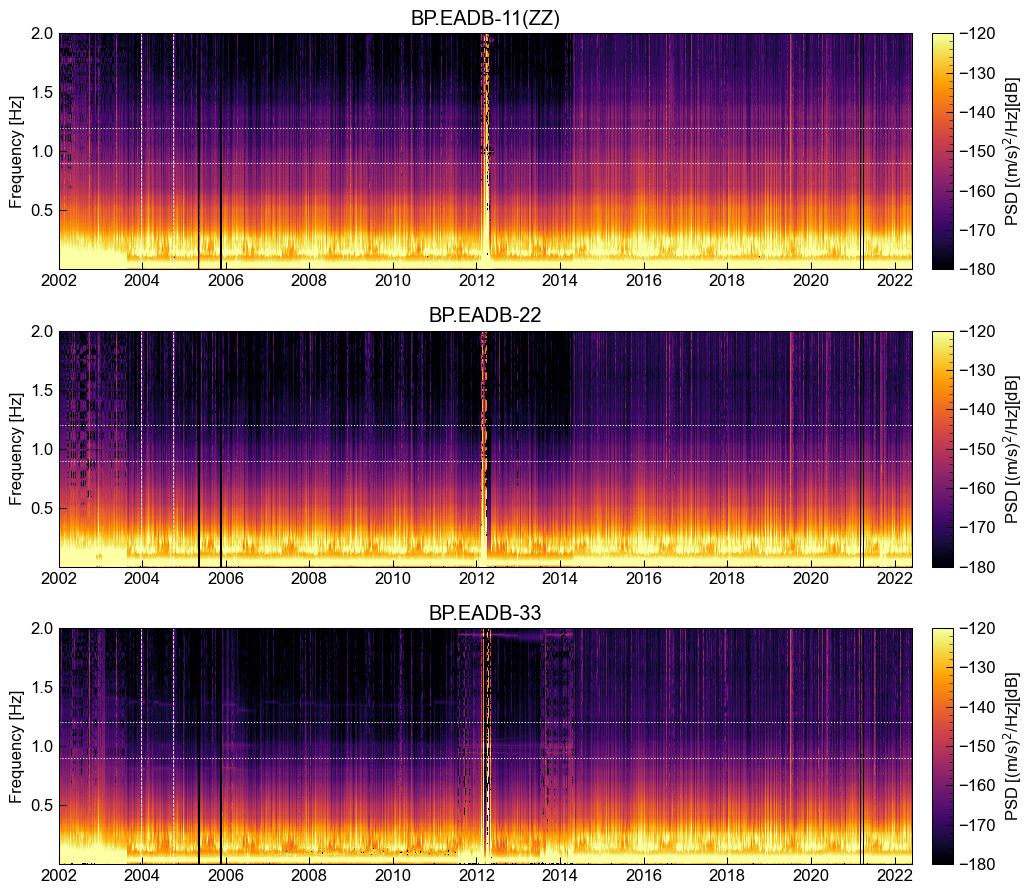

In [7]:
cmap = "inferno" #"viridis"

st = datetime.datetime(2002, 1, 1)
et = datetime.datetime(2022, 6, 1)

vmin  = -180
vmax = -120

fig, axs = plt.subplots(3, 1, figsize=(10.5, 9.1), sharex=False, gridspec_kw={'height_ratios': [1, 1, 1]})

for i, comp in enumerate(complist):
    ax = axs[i]
    tvec_all = ppsd_dict[f"{comp}-tvec_all"]
#     Spfreq_DSP = ppsd_dict[f"{comp}-Spfreq_DSP"]
    Sp_all = ppsd_dict[f"{comp}-Sp_all"]

    h1 = ax.pcolormesh(tvec_all, Spfreq, pow2db(Sp_all), cmap=cmap, norm=Normalize(vmin = vmin, vmax=vmax), rasterized=True)
    
#     for c in h1.collections:
#         c.set_rasterized(True)
            
    # plot colorbar
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="2.5%", pad=0.2)
    fig.add_axes(ax_cb)
    cb = fig.colorbar(ScalarMappable(norm=h1.norm, cmap=h1.cmap), cax=ax_cb,
                     orientation='vertical', label="PSD [(m/s)$^2$/Hz][dB]")
    # cb.set_ticks([0, 1.0])

    # plot dashed lines to specify the frequency range and major earthquakes
    hlines = [0.9, 1.2] 
    for hline in hlines:
        ax.axhline(hline,
                    color='w',
                    linewidth=0.8,
                    linestyle=':',
                    zorder=2)

    vlines = [datetime.datetime(2003, 12, 22), datetime.datetime(2004, 9, 28)] #, datetime.datetime(2014, 8, 24)] 
    for vline in vlines:
        ax.axvline(vline,
                    color='w',
                    linewidth=0.6,
                    linestyle='--',
                    zorder=2)

    ax.set_xlim([st, et])
    ax.set_ylim([0, 2.0])
    ax.set_yticks([0.5, 1.0, 1.5, 2.0])
    ax.set_ylabel("Frequency [Hz]")
    
    if comp=="11":
        ax.set_title("{}-{}(ZZ)".format(sta, comp))
    else:
        ax.set_title("{}-{}".format(sta, comp))
        
    ax.xaxis.set_major_locator(mdates.YearLocator(2, month=1, day=1))
    ax.minorticks_off()
    xfmt = dates.DateFormatter('%Y')
    ax.xaxis.set_major_formatter(xfmt)
#     plt.setp(ax.xaxis.get_majorticklabels(), rotation=-45)

fig.tight_layout()
foname = (output_imgdir+"/test_PPSD_{}_allcomp.png".format(sta))
plt.savefig(foname, dpi=300)

foname = (output_imgdir+"/PPSD_{}_allcomp.eps".format(sta))
plt.savefig(foname)

# Plot all PPSD

In [8]:
# Parameters
cmap = "inferno" #"viridis"
st = datetime.datetime(2002, 1, 1)
et = datetime.datetime(2022, 6, 1)
vmin  = -180
vmax = -120
complist = ["11", "22", "33"]

# read the file names
filelist = glob(datadir+"/*.jld2")

# search station pairs
stations = []
for fname in filelist:
    stations.append(os.path.basename(fname).split(".jld2")[0].split("_")[1].split("-")[0])
    
stations = np.unique(stations)

for sta in stations:
    print(f"start processing {sta}.")
# sta = stations[0]

    ppsd_dict = dict()
    for comp in complist:
        finame= datadir+f"/PPSDdata_{sta}-{sta}-{comp}.jld2"
        # read psd data
        fi = h5py.File(finame, "r")
        tvec_all = [datetime.datetime.fromtimestamp(x) for x in fi["tvec_all"][()]]
        fs = fi["fs"][()]
        Spfreq_DSP = fi["Spfreq"][()]
        Sp_all = np.transpose(fi["Sp_all"][()])
        ppsd_dict[f"{comp}-tvec_all"] = tvec_all
        ppsd_dict[f"{comp}-fs"] = fs
        ppsd_dict[f"{comp}-Spfreq_DSP"] = Spfreq_DSP
        ppsd_dict[f"{comp}-Sp_all"] = Sp_all

        # recompute the list of rfftfreq with numpy
        Nlag = 2*(Sp_all.shape[0]-1) + 1
        Spfreq = np.fft.rfftfreq(Nlag, d=1/fs)
        dfreq = Spfreq[2] - Spfreq[1]

        # assert if the step size of frequency band is identical to Julia DSP.rfftfreq
        assert np.abs(Spfreq_DSP[2] - dfreq)  < 1e-12

    fig, axs = plt.subplots(3, 1, figsize=(10.5, 9.1), sharex=False, gridspec_kw={'height_ratios': [1, 1, 1]})

    # re-define Spfreq by component 11
    Nlag = 2*(ppsd_dict[f"{comp}-Sp_all"].shape[0]-1) + 1
    Spfreq = np.fft.rfftfreq(Nlag, d=1/fs)
    
    for i, comp in enumerate(complist):
        ax = axs[i]
        tvec_all = ppsd_dict[f"{comp}-tvec_all"]
    #     Spfreq_DSP = ppsd_dict[f"{comp}-Spfreq_DSP"]
        Sp_all = ppsd_dict[f"{comp}-Sp_all"]

        h1 = ax.pcolormesh(tvec_all, Spfreq, pow2db(Sp_all), cmap=cmap, norm=Normalize(vmin = vmin, vmax=vmax))

        # plot colorbar
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="2.5%", pad=0.2)
        fig.add_axes(ax_cb)
        cb = fig.colorbar(ScalarMappable(norm=h1.norm, cmap=h1.cmap), cax=ax_cb,
                         orientation='vertical', label="PSD [(m/s)$^2$/Hz][dB]")
        # cb.set_ticks([0, 1.0])

        # plot dashed lines to specify the frequency range and major earthquakes
        hlines = [0.9, 1.2] 
        for hline in hlines:
            ax.axhline(hline,
                        color='w',
                        linewidth=0.8,
                        linestyle=':',
                        zorder=2)

        vlines = [datetime.datetime(2003, 12, 22), datetime.datetime(2004, 9, 28)] #, datetime.datetime(2014, 8, 24)] 
        for vline in vlines:
            ax.axvline(vline,
                        color='w',
                        linewidth=0.6,
                        linestyle='--',
                        zorder=2)

        ax.set_xlim([st, et])
        ax.set_ylim([0, 2.0])
        ax.set_yticks([0.5, 1.0, 1.5, 2.0])
        ax.set_ylabel("Frequency [Hz]")

        if comp=="11":
            ax.set_title("{}-{}(ZZ)".format(sta, comp))
        else:
            ax.set_title("{}-{}".format(sta, comp))

        ax.xaxis.set_major_locator(mdates.YearLocator(2, month=1, day=1))
        ax.minorticks_off()
        xfmt = dates.DateFormatter('%Y')
        ax.xaxis.set_major_formatter(xfmt)
    #     plt.setp(ax.xaxis.get_majorticklabels(), rotation=-45)

    fig.tight_layout()

    foname = (output_imgdir+"/PPSD_{}_allcomp.jpg".format(sta))
    plt.savefig(foname, dpi=400)
    plt.close()
    plt.clf()

start processing BP.CCRB.
start processing BP.EADB.
start processing BP.FROB.
start processing BP.GHIB.
start processing BP.JCNB.
start processing BP.JCSB.
start processing BP.LCCB.
start processing BP.MMNB.
start processing BP.RMNB.
start processing BP.SCYB.
start processing BP.SMNB.
start processing BP.VARB.
start processing BP.VCAB.


<Figure size 640x480 with 0 Axes>